In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import keras
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import cifar10
import pickle

# import parameters
#from cifar10_params import *

img_rows, img_cols, img_chns = 32, 32, 3
latent_dim = 60
intermediate_dim = 512
epsilon_std = 1.0
epochs = 15
filters = 60
num_conv = 3
batch_size = 25

"""
loading vae model back is not a straight-forward task because of custom loss layer.
we have to define some architecture back again to specify custom loss layer and hence to load model back again.
"""

# tensorflow or theano
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)

original_img_size = (img_rows, img_cols, img_chns)
    
# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# Custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        print(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        print(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        print(inputs)
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        loss = [1]
        self.add_loss(loss, inputs=inputs)
        return x


Using TensorFlow backend.


In [2]:
def my_vae_loss(x, x_decoded_mean_squash):
    x = K.flatten(x)
    x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
    xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return K.mean(xent_loss + kl_loss)

In [3]:
# load saved models
vae = keras.models.load_model('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs),
                                 custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'my_vae_loss':my_vae_loss})
encoder = keras.models.load_model('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs),
                                     custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'my_vae_loss':my_vae_loss})
generator = keras.models.load_model('../models/cifar10_%d*%d_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs),
                                       custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'my_vae_loss':my_vae_loss})

# load history if saved
fname = '../models/cifar10_ld_%d*%d_%d_conv_%d_id_%d_e_%d_history.pkl' % (img_rows, img_cols, latent_dim, num_conv, intermediate_dim, epochs)
try:
    with open(fname, 'rb') as fo:
        history = pickle.load(fo)
    print(history)
except:
    print("training history not saved")


/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


{'loss': [639.71367768843584, 580.3553146525104, 569.30481475030876, 563.05808918876164, 557.14377568094164, 552.40113293326795, 548.79727252771511, 546.00641928819869, 543.70834048666154, 541.12684464107781, 539.43451723973806, 537.866784348289, 536.25834281321988, 534.70846382977311, 534.60415643494071], 'val_loss': [596.48968080032705, 578.15518354075823, 573.39690594340482, 567.00054600442104, 561.65102652616281, 557.6268182798874, 555.67419528221899, 553.90575272907586, 551.46161740325215, 549.9593240900557, 550.28937784830725, 551.35232378346052, 547.32102930823032, 548.42521277139349, 546.88985661942831]}


In [10]:
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 3)    39          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 60)   780         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 60)   32460       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

../img/Fall/cacharel/10.jpg


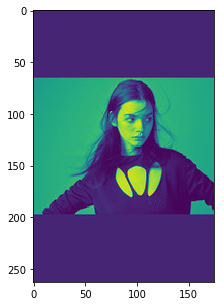

../img/Fall/a-w-a-k-e-/7.jpg


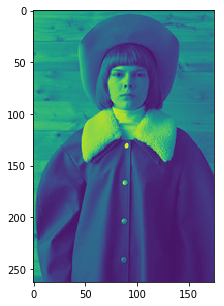

../img/Fall/a-w-a-k-e-/17.jpg


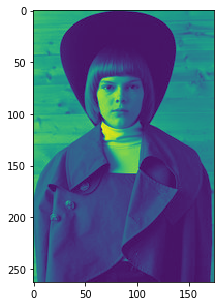

../img/Fall/a-w-a-k-e-/53.jpg


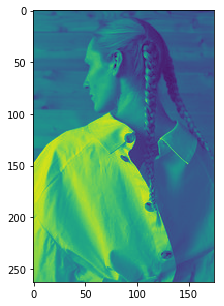

../img/Fall/a-w-a-k-e-/52.jpg


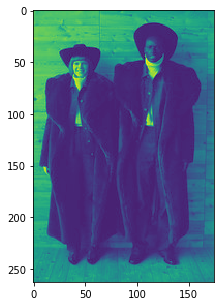

../img/Fall/a-w-a-k-e-/30.jpg


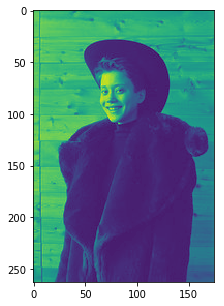

../img/Fall/a-w-a-k-e-/68.jpg


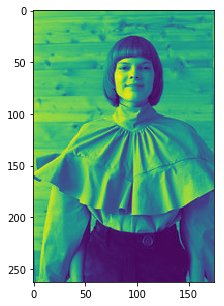

../img/Fall/a-w-a-k-e-/4.jpg


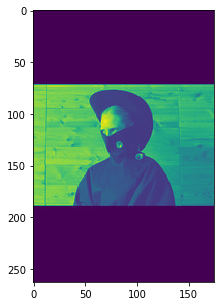

../img/Fall/a-w-a-k-e-/38.jpg


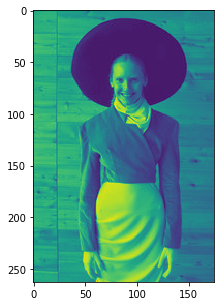

../img/Fall/a-w-a-k-e-/64.jpg


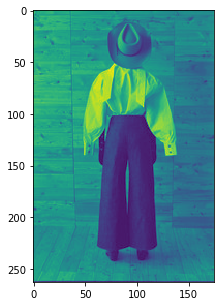

../img/Fall/a-w-a-k-e-/79.jpg


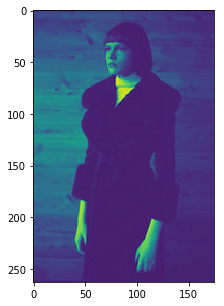

../img/Fall/a-w-a-k-e-/56.jpg


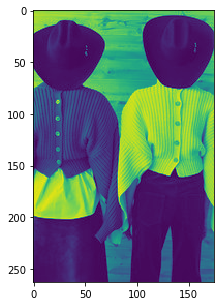

../img/Fall/a-w-a-k-e-#collection/7.jpg


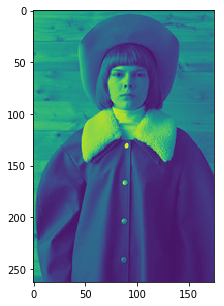

../img/Fall/a-w-a-k-e-#collection/17.jpg


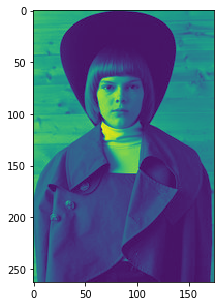

../img/Fall/a-w-a-k-e-#collection/30.jpg


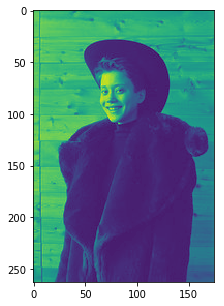

../img/Fall/a-w-a-k-e-#collection/4.jpg


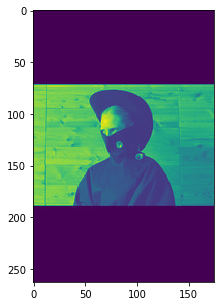

../img/Fall/a-w-a-k-e-#collection/38.jpg


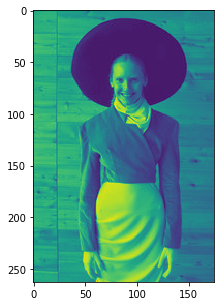

Input size (3867, 32, 32, 3)
(32, 32, 3)
(3093, 32, 32, 3)


In [4]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split

show_name = "Fall"
src_dir = "../img/%s" % show_name

input_files = []
for root, dirs, files in os.walk(src_dir):
    for f in files:
        if os.path.splitext(f)[-1].lower() in [".jpg", ".JPG"]:
            os.path.join(root, f)
            input_files.append(os.path.join(root, f))
            
#input_files = [os.path.join(src_dir, f) for f in os.listdir(src_dir) if f.endswith(".jpg")]
#imgs = [Image.open(im).convert('RGB').resize((172, 260), Image.ANTIALIAS) for im in input_files]
#lwf_immatrix = np.array([np.array(im) for im in imgs])

lwf_immatrix = []
for im in input_files:
    img = Image.open(im)
    if len(np.array(img).shape) != 3:
        print(im)
        plt.figure(figsize=(5, 5))
        plt.imshow(np.array(img))
        plt.show()
    else:
        #lwf_immatrix.append(np.array(img.resize((172, 260), Image.ANTIALIAS)))
        lwf_immatrix.append(np.array(img.resize((img_rows, img_cols), Image.ANTIALIAS))) # change in img_row! in the above cell

lwf_immatrix = np.array(lwf_immatrix)
        
    
#lwf_immatrix = np.array([np.array(Image.open(im)) for im in input_files])
print("Input size", lwf_immatrix.shape)

#plt.figure(figsize=(5, 5))
#plt.imshow(lwf_immatrix[0])
#plt.show()

x_train, x_test, _, _ = train_test_split(lwf_immatrix, [0]*len(lwf_immatrix), test_size=0.20, random_state=42)

original_img_size = lwf_immatrix[0].shape

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
print(original_img_size)
print(x_train.shape)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

In [23]:
vae.get_layer(name='dense_2').evaluate()

AttributeError: 'Dense' object has no attribute 'evaluate'

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


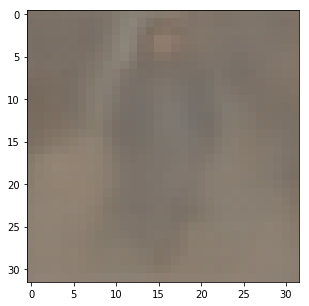

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


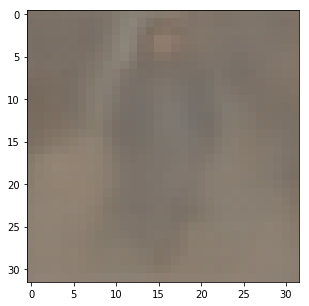

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


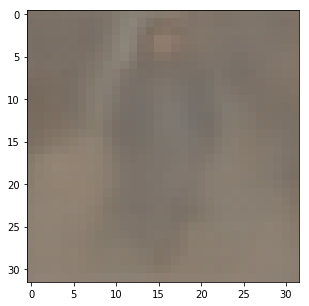

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


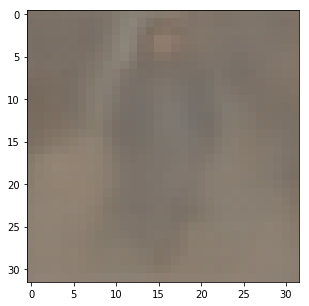

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


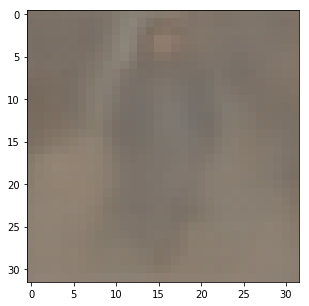

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


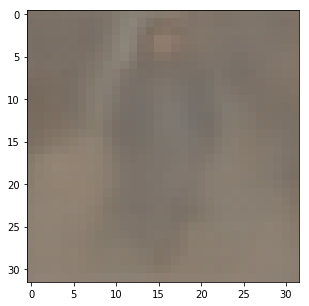

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


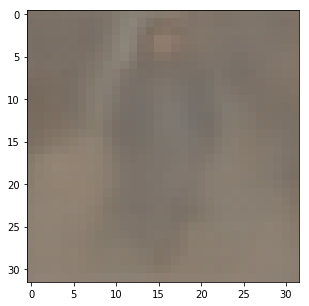

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


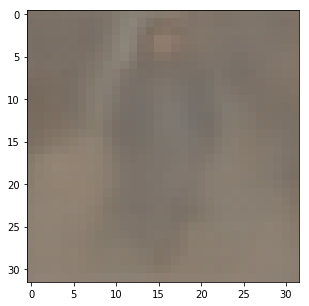

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


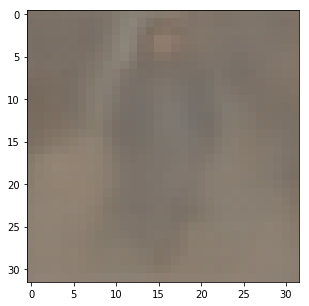

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


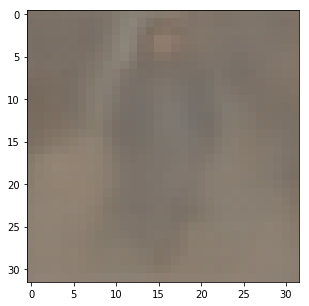

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


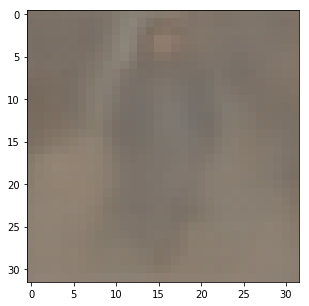

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


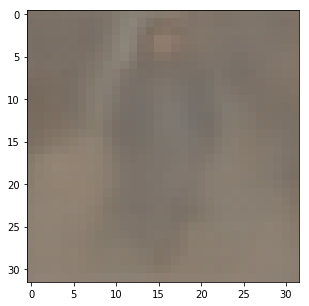

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


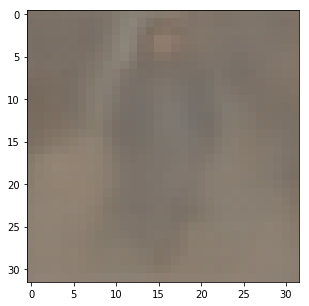

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


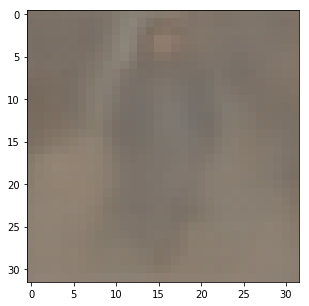

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


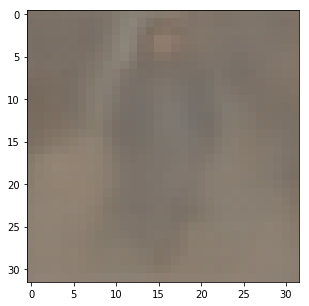

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


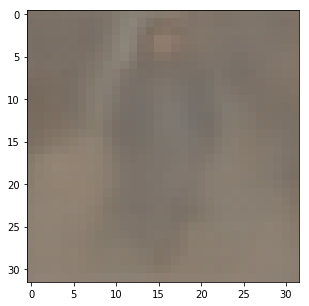

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


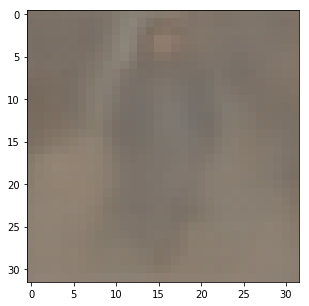

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


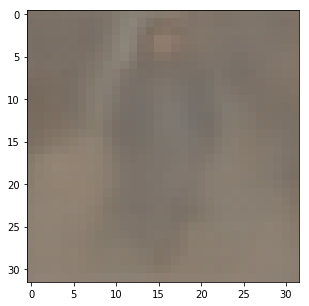

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


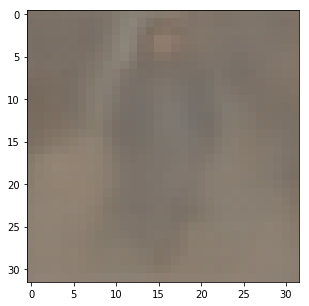

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


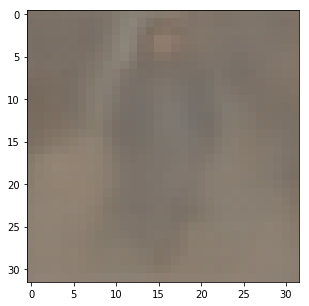

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


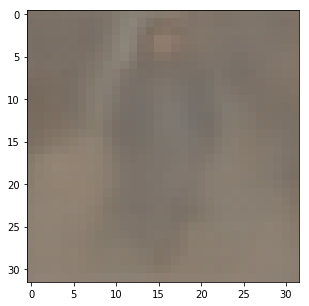

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


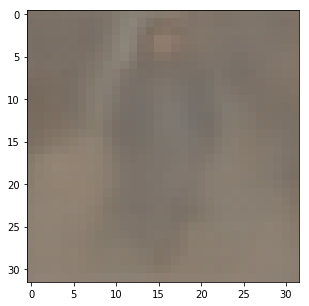

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


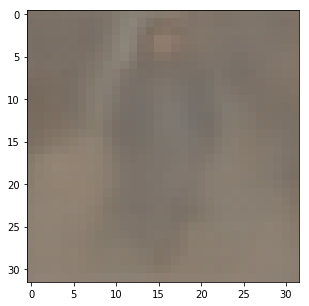

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


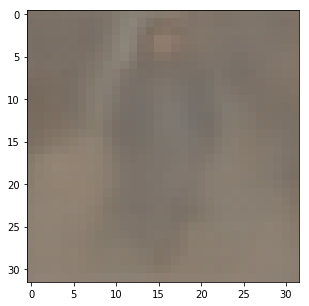

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]] 1


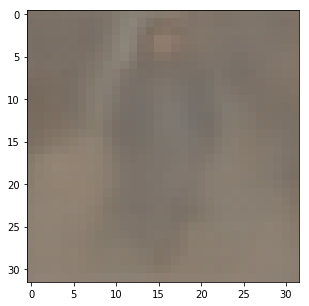

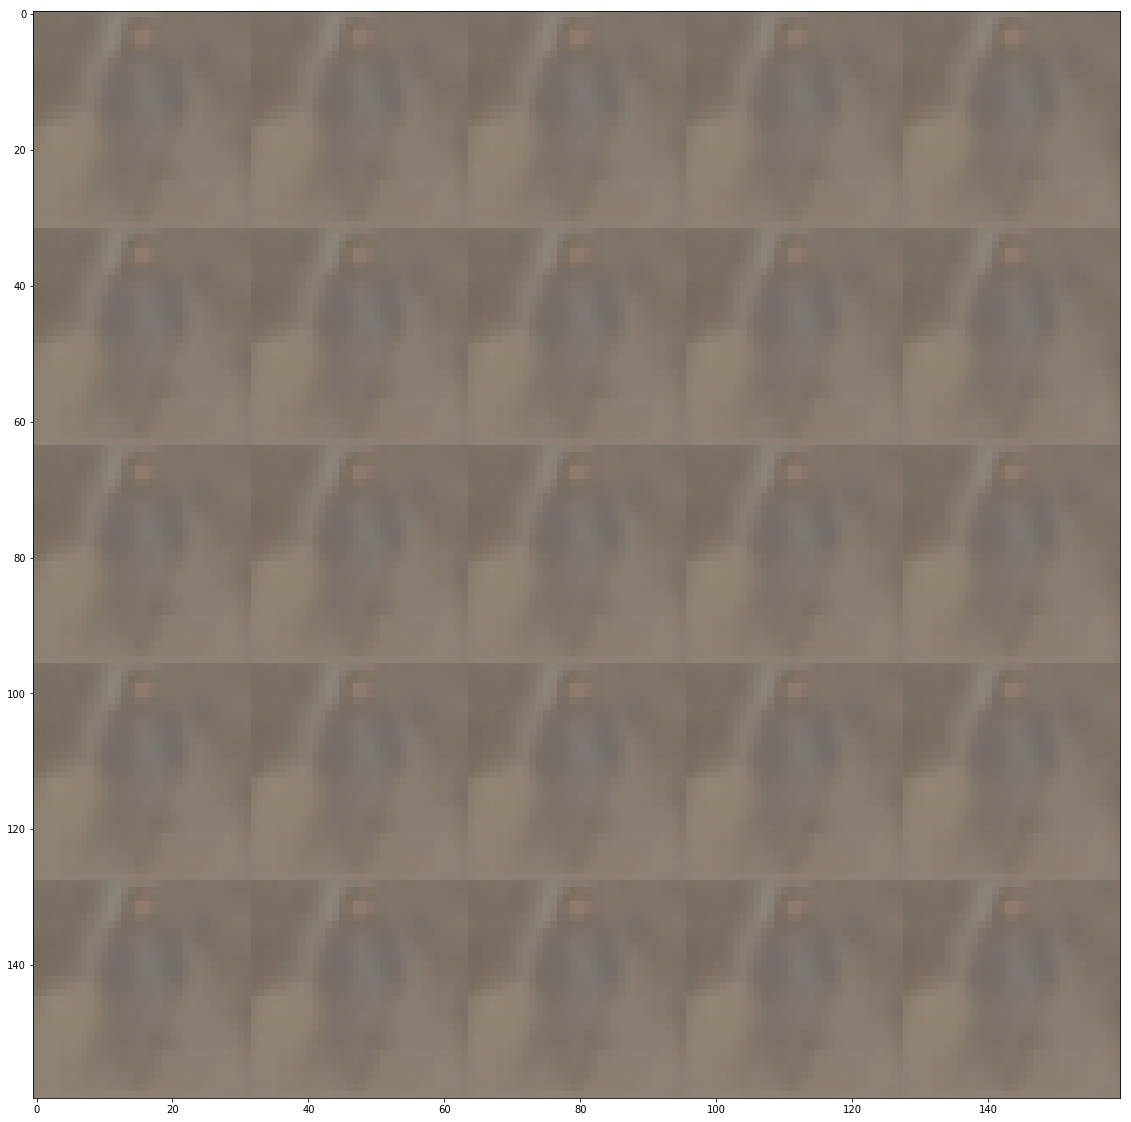

In [7]:
# display images generated from randomly sampled latent vector
n = 5
figure = np.zeros((img_cols * n, img_rows * n, img_chns))


for i in range(n):
    for j in range(n):
        z_sample = [0] * (latent_dim-1)
        z_sample.extend([1])
        z_sample = np.array([z_sample])
        #z_sample = np.array([np.random.uniform(-1,1,size=latent_dim)])
        print(z_sample, len(z_sample))
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_cols, img_rows, img_chns)
        #print(img)
        figure[i * img_cols: (i + 1) * img_cols, j * img_rows: (j + 1) * img_rows] = img

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')
#plt.imshow(figure)
#plt.show()

In [12]:
# load dataset to plot latent space
(x_train, _), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

if latent_dim == 3:
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1],x_test_encoded[:, 2], c=y_test)
    plt.show()

if latent_dim == 2:
    # display a 2D plot of the classes in the latent space
    x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
    plt.figure(figsize=(6, 6))
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
    plt.colorbar()
    plt.show()

"""
# display a 2D manifold of the images
n = 15  # figure with 15x15 images
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,
               j * img_size: (j + 1) * img_size] = img
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()
"""

# display images generated from randomly sampled latent vector
n = 15
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

        #plt.figure(figsize=(5, 5))
        #plt.imshow(img, cmap='Greys_r')
        #plt.show()


plt.figure(figsize=(20, 20))
plt.imshow(figure, cmap='Greys_r')

[<tf.Tensor 'input_2_6:0' shape=(?, 92, 92, 3) dtype=float32>, <tf.Tensor 'conv2d_10_5/Sigmoid:0' shape=(?, ?, ?, 3) dtype=float32>]
Tensor("custom_variational_layer_2_4/Reshape:0", shape=(?,), dtype=float32)
Tensor("custom_variational_layer_2_4/Reshape_1:0", shape=(?,), dtype=float32)


ValueError: When passing a list as loss, it should have one entry per model outputs. The model has 1 outputs, but you passed loss=[]

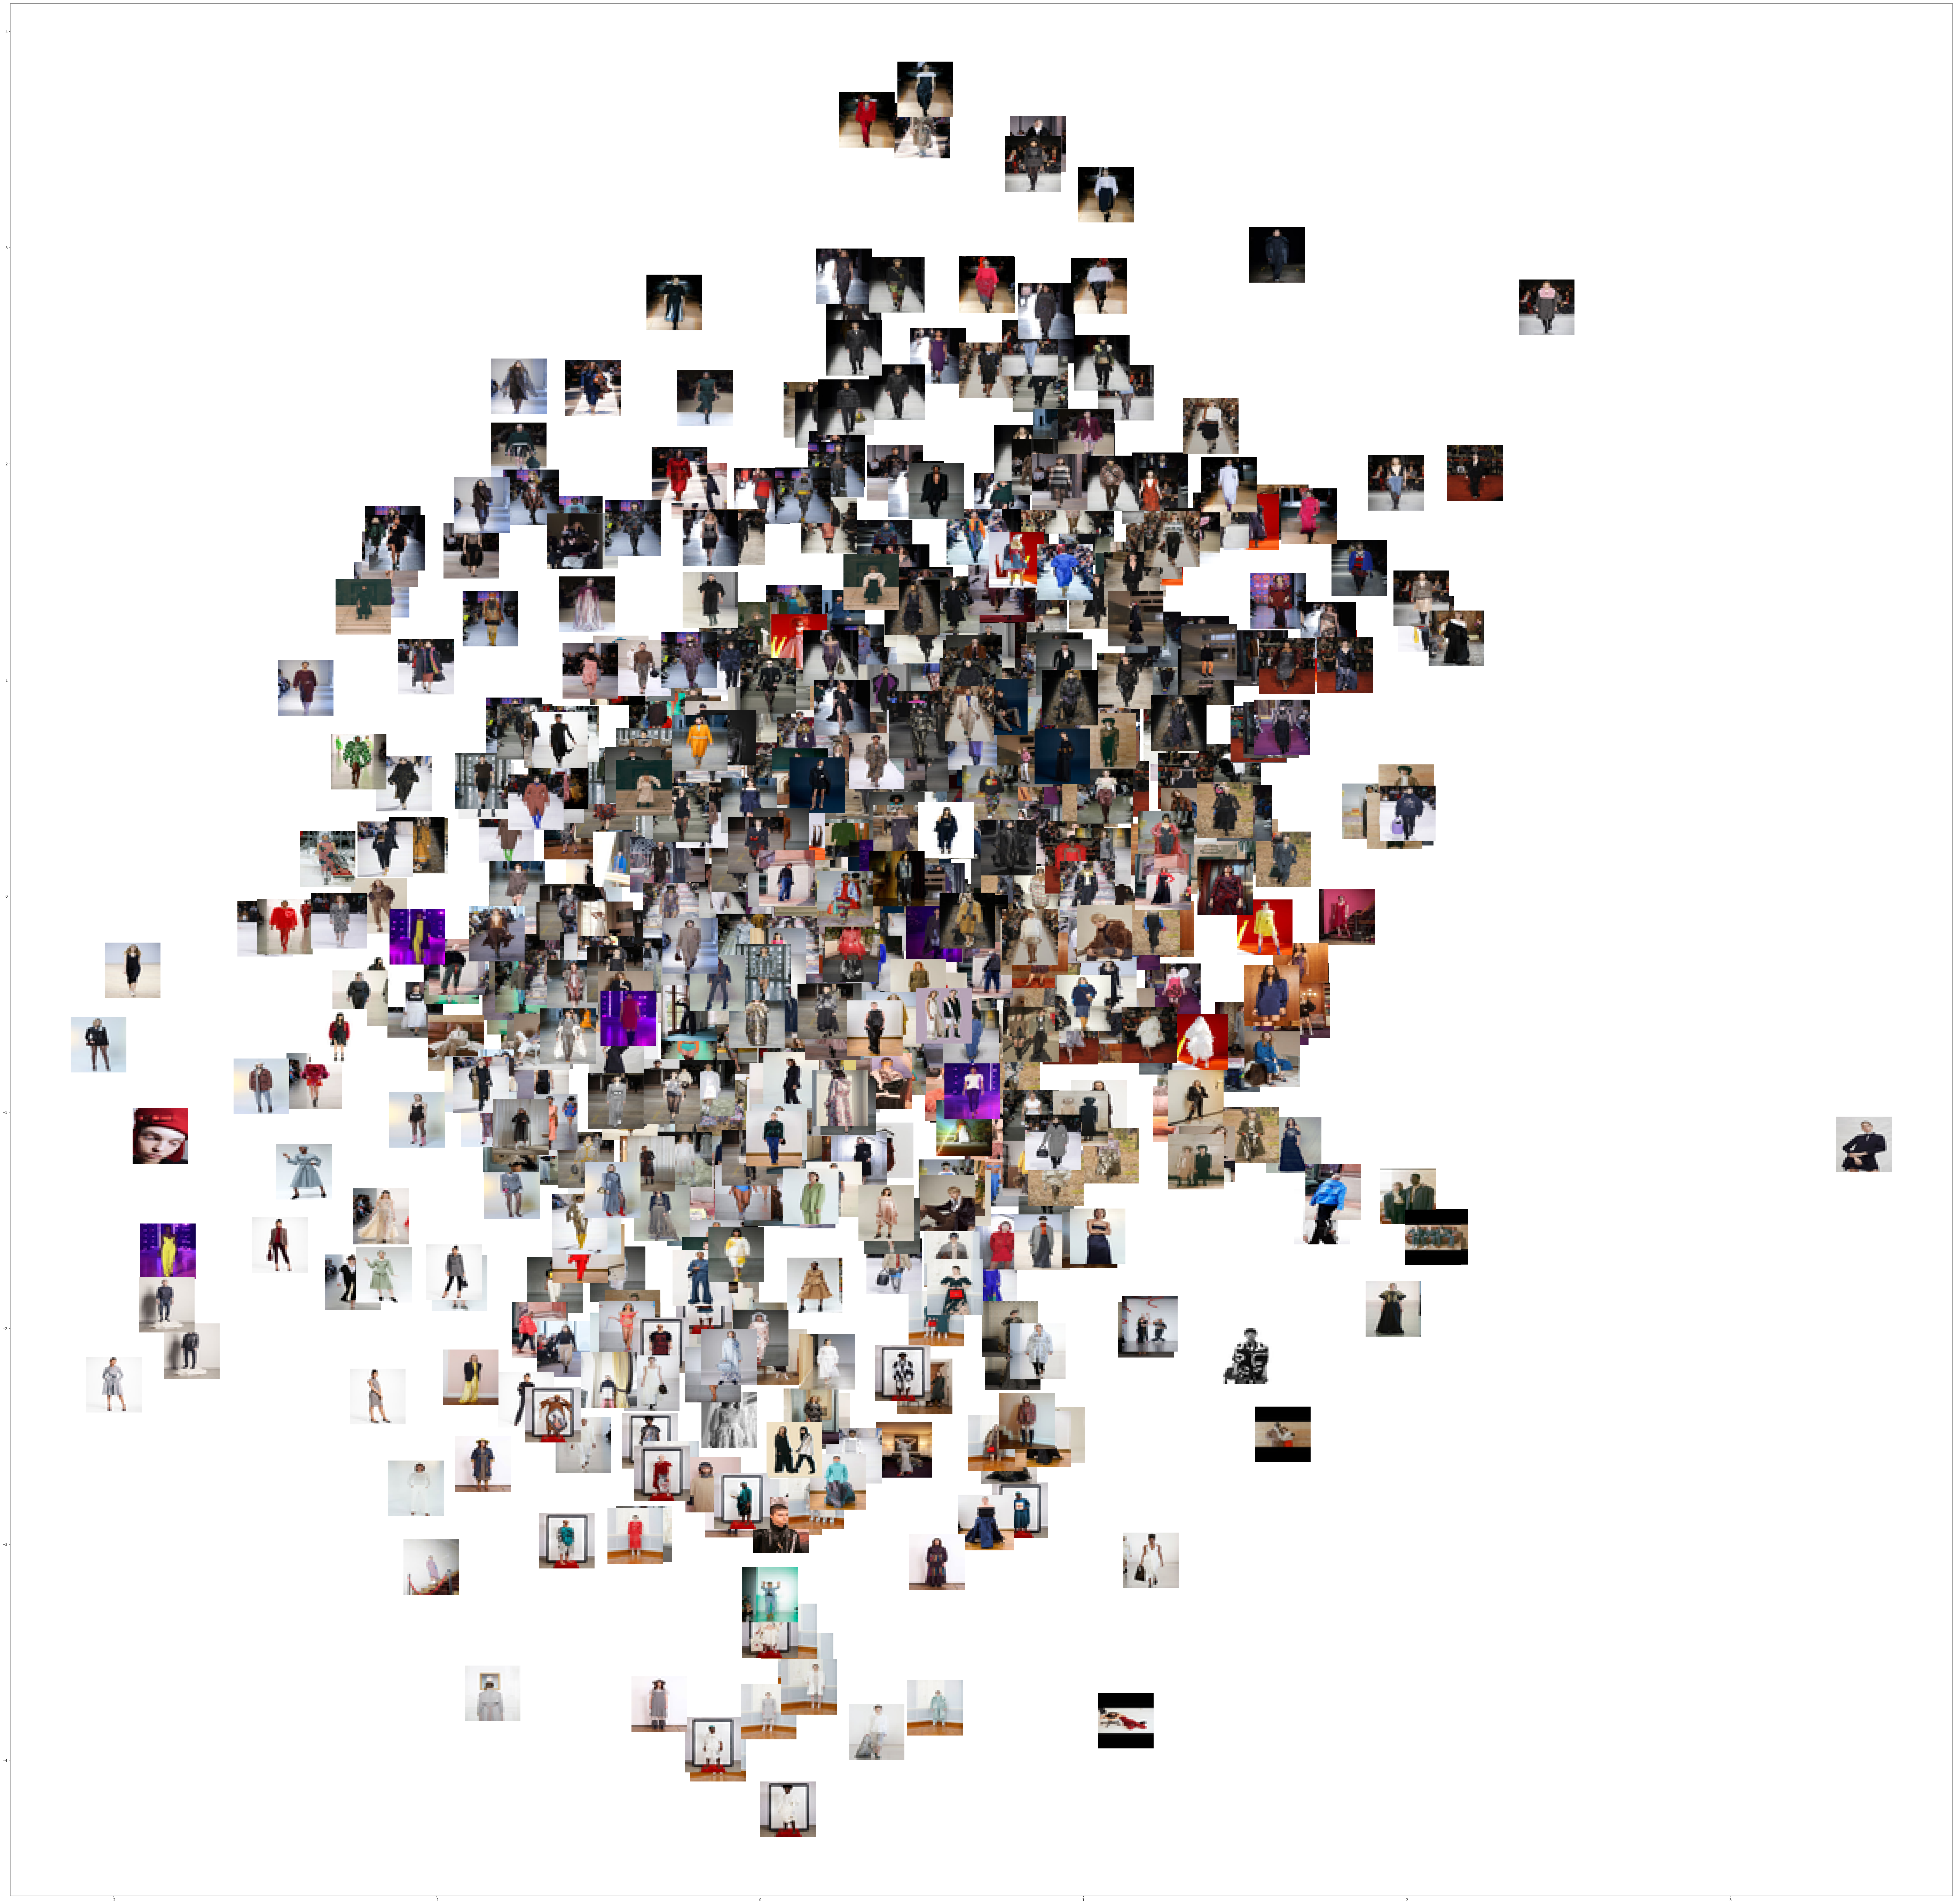

In [11]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox


def getImage(img,zoom=5):
    return OffsetImage(img,zoom=zoom)

imgs = x_test
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
x = x_test_encoded[:, 2]
y = x_test_encoded[:, 3]

fig, ax = plt.subplots(figsize=(100, 100))
ax.scatter(x, y) 

artists = []
for x0, y0, img in zip(x, y, imgs):
    ab = AnnotationBbox(getImage(img), (x0, y0), frameon=False)
    artists.append(ax.add_artist(ab))